### Imports

In [41]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd

### Constants

In [42]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


### Functions definitions

In [43]:
preprocess = transforms.Compose([
             transforms.ToTensor(), 
             transforms.Normalize(mean, std)])

transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [44]:
# Data pre-process.
def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np

In [45]:
def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

In [46]:
def dream(image, model, iterations, lr):
    Tensor = torch.FloatTensor
    image = Variable(Tensor(image), requires_grad=True)
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()

In [47]:
def deep_dream(image, model, iterations, lr, octave_scale, num_octaves):
    image = transform(image).unsqueeze(0).cpu().data.numpy()
    octaves = [image]
    for _ in range(num_octaves - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(tqdm.tqdm(octaves[::-1], desc="Dreaming")):
        if octave > 0:
            detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)
        input_image = octave_base + detail
        dreamed_image = dream(input_image, model, iterations, lr)
        detail = dreamed_image - octave_base

    return deprocess(dreamed_image)


### Parameters setting


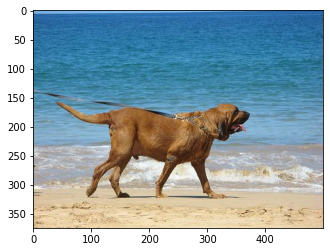

In [48]:
image = Image.open("Images/n02088466-bloodhound/n02088466_3184.jpg").convert("RGB")
at_layer = 25
lr = 0.03
iterations = 50
octave_scale = 1.4
num_octaves = 20
plt.imshow(image)

### Load and prepare model


In [49]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=120,bias=True)
model.load_state_dict(torch.load("models/m10_dict.pt"))
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Run deep dreaming

In [50]:
dreamed_image = deep_dream(
        image,
        model,
        iterations=iterations,
        lr=lr,
        octave_scale=octave_scale,
        num_octaves=num_octaves,
    )

filename = 'out_1.jpg'
os.makedirs("outputs", exist_ok=True)
# plt.figure(figsize=(20, 20))
plt.imshow(dreamed_image)
plt.show()
plt.imsave(f"outputs/output_{filename}", dreamed_image)

Dreaming:   0%|          | 0/20 [00:00<?, ?it/s]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


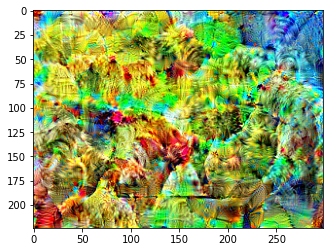

In [51]:
plt.imshow(dreamed_image)
plt.show()